# Multiple-objective portfolio optimization

# Portfolio optimization

In [14]:
from pathlib import Path
import logging

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from asset import Asset


c:\Users\Jurek\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [15]:
sns.set_theme()


In [16]:
ASSETS_ORDER = [
    "SuperFuture",
    "Apples",
    "WorldNow",
    "Electronics123",
    "Photons",
    "SpaceNow",
    "PearPear",
    "PositiveCorrelation",
    "BetterTechnology",
    "ABCDE",
    "EnviroLike",
    "Moneymakers",
    "Fuel4",
    "MarsProject",
    "CPU-XYZ",
    "RoboticsX",
    "Lasers",
    "WaterForce",
    "SafeAndCare",
    "BetterTomorrow",
]


In [17]:
ASSETS_DIR = Path("data/Bundle3/")
ASSETS = [Asset(asset_path) for asset_path in ASSETS_DIR.iterdir() if asset_path.suffix == ".txt"]
ASSETS = sorted(ASSETS, key=lambda asset: ASSETS_ORDER.index(asset.name))

In [18]:
[asset.name for asset in ASSETS]

['SuperFuture',
 'Apples',
 'WorldNow',
 'Electronics123',
 'Photons',
 'SpaceNow',
 'PearPear',
 'PositiveCorrelation',
 'BetterTechnology',
 'ABCDE',
 'EnviroLike',
 'Moneymakers',
 'Fuel4',
 'MarsProject',
 'CPU-XYZ',
 'RoboticsX',
 'Lasers',
 'WaterForce',
 'SafeAndCare',
 'BetterTomorrow']

In [19]:
asset = ASSETS[4]
asset.name


'Photons'

In [20]:
def get_expected_return(asset: Asset, last_no: int = 25, plot: bool = False) -> float:
    X = np.array(list(range(len(asset.data_points)))).reshape(-1, 1)
    y = np.array(asset.data_points)

    lin_reg = LinearRegression()
    lin_reg.fit(X[-last_no:], y[-last_no:])

    X_future = np.array(list(range(len(asset.data_points) + last_no))).reshape(-1, 1)
    last_pred = max(lin_reg.predict(X_future)[-1], 0) # Predicted value can't be negative

    if plot:
        plt.plot(X, y, "b.")
        plt.plot(X_future, lin_reg.predict(X_future), "r-")
        plt.show()

    return round((last_pred - y[-1]) / y[-1], 4)

In [191]:
def format_to_range(expected_results: np.array):
    # Format results to range [-1, 1]
    min_val = min(expected_results)
    max_val = max(expected_results)

    return 2 * (expected_results - min_val) / (max_val - min_val) - 1


def get_expected_return_prophet(asset: Asset, plot: bool = False) -> float:
    m = Prophet(growth="logistic") #tak?
    data = asset.data_points

    df = pd.DataFrame({"y": data, "ds": pd.date_range("2023-01-01", periods=len(data), freq="D")})
    df['cap'] = np.mean(data) * 1.5
    df['floor'] = np.mean(data) * 0.5

    # Disable prophet and cmdstanpy logging
    logging.getLogger("prophet").setLevel(logging.ERROR)
    logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
    
    m.fit(df)
    
    
    future = m.make_future_dataframe(periods=100)
    future['cap'] = np.mean(data) * 1.5
    future['floor'] = np.mean(data) * 0.5
    forecast = m.predict(future)

    if plot:
        m.plot(forecast)
        plt.show()

    yhat = forecast["yhat"].values[-1]
    yhat_lower = forecast["yhat_lower"].values[-1]
    yhat_upper = forecast["yhat_upper"].values[-1]

    diff = yhat_upper + yhat_lower - 2 * yhat

    last = data[-1]

    return round((yhat + diff - last) / last, 4)

In [192]:
expected_results = []
for asset in ASSETS:
    expected_results.append(get_expected_return_prophet(asset))

expected_results = format_to_range(np.array(expected_results))
expected_results


array([-0.40025341, -0.07363086,  0.51034774, -0.91524708, -0.68689286,
        0.16485992,  0.84260172, -1.        ,  0.91074194,  0.06799944,
       -0.42108968, -0.42475011,  0.25299169, -0.15190764,  1.        ,
       -0.40447698, -0.85330142, -0.56666197,  0.75137266, -0.93777277])

In [194]:
ASSETS_MATRIX = np.array([ASSETS[i].data_points for i in range(20)]) 

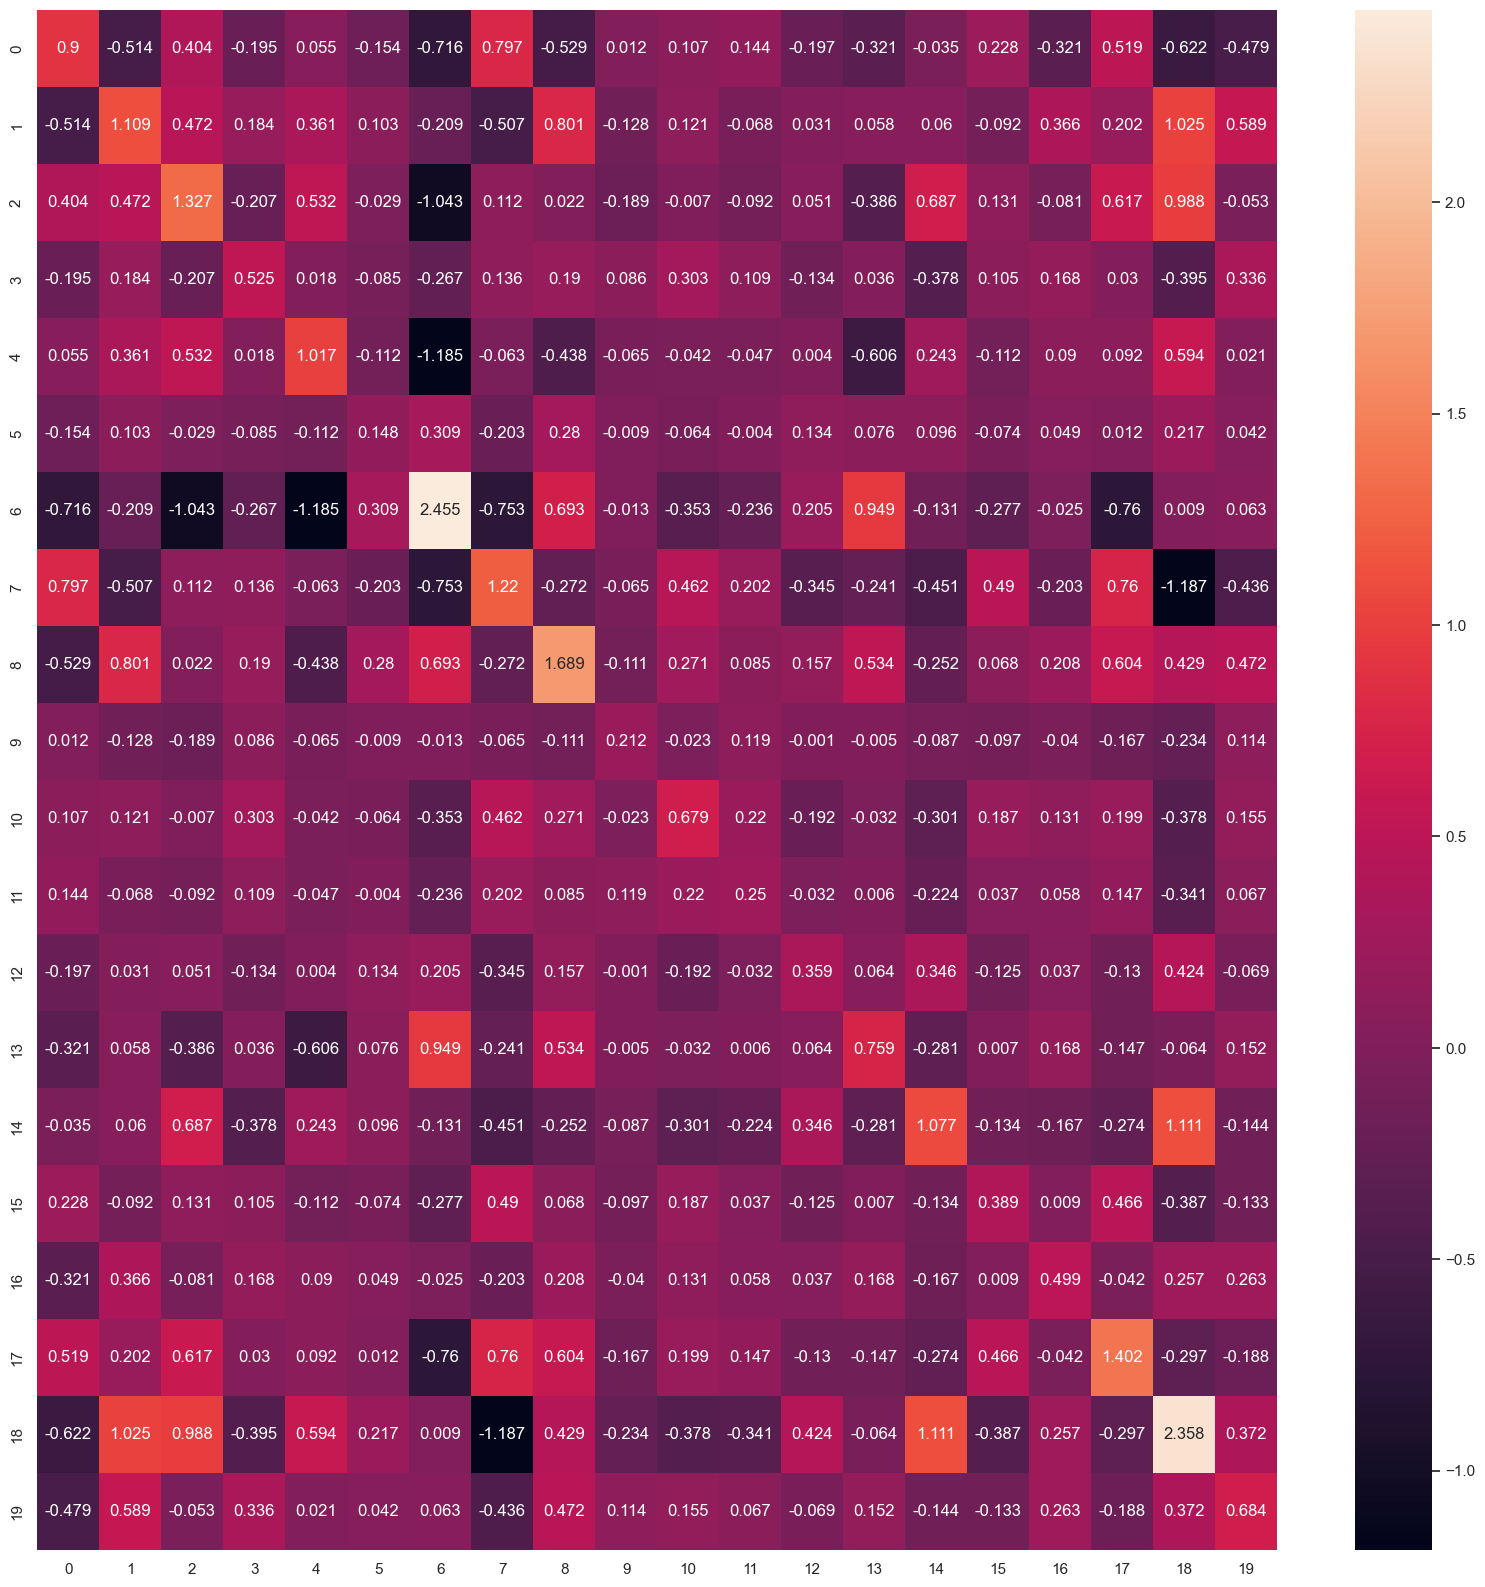

In [195]:
cov_matrix = np.round(np.cov(ASSETS_MATRIX, bias=True), 3)
plt.figure(figsize=(20, 20))
sns.heatmap(cov_matrix, annot=True, fmt='g')
plt.show()

In [196]:
# A = matrix([1, 1, ..., 1]) (1x20)
# b = matrix([1, 1, ..., 1]) (20x1)

# G = -I (20x20)
# h = matrix([0, 0, ..., 0]) (20x1)

# c = Return (20x1)
# Q = Covariance (20x20)

In [197]:
A = matrix(np.ones(20)).T
b = matrix(1.0)

G = matrix(-np.eye(20))
h = matrix(np.zeros(20))

c = matrix(-expected_results)
Q = matrix(2*cov_matrix)

In [198]:
solQP = solvers.qp(Q, c, G, h, A, b)


In [199]:
arr = np.array(solQP['x'])
arr_round = np.round(arr, 5)

invest = []
for ind, elem in enumerate(arr_round):
    elem, = elem
    if elem < 0.0001:
        continue

    invest.append((ind, elem))

x = solQP['x']

print("Primal objective:", solQP['primal objective'])
print(f"\nTotal expected return: {-np.dot(c.T, x).flatten()[0]}")
print(f"Total expected risk: {0.5 * np.dot(x.T, np.dot(Q, x)).flatten()[0]}")
print(f"Number of assets to invest in: {len(invest)}")

Primal objective: -0.4823362962292287

Total expected return: 0.8163584355060057
Total expected risk: 0.334022139276777
Number of assets to invest in: 4


In [200]:
for ind, elem in invest:
    print(f"{ASSETS[ind].name} - {elem}")

PearPear - 0.09167
BetterTechnology - 0.27029
ABCDE - 0.15567
CPU-XYZ - 0.48237


In [201]:
print("Final weight vector:")
d = list(arr_round.flatten())
" ".join(map(str, [int(d) if d == 0 else d for d in list(arr_round.flatten())]))

Final weight vector:


'0 0 0 0 0 0 0.09167 0 0.27029 0.15567 0 0 0 0 0.48237 0 0 0 0 0'

### Dates from 2023-01-01 to 2023-04-11 represent the [0; 300] time interval.
### Dates from 2023-04-12 to 2023-07-20 represent the [300; 400] time interval.

Invest in:
-----------------

 6 - PearPear    : 0.09167


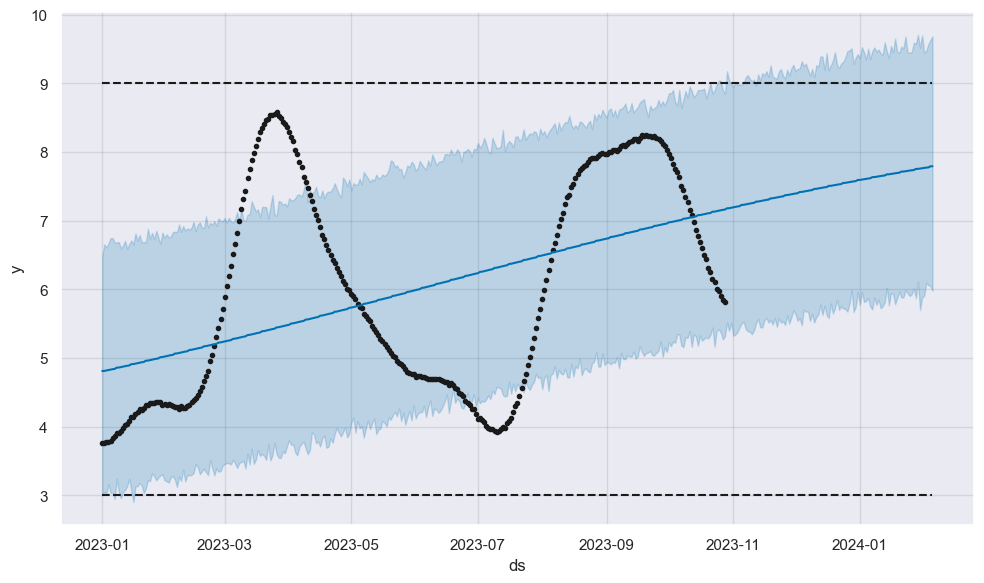

 8 - BetterTechnology: 0.27029


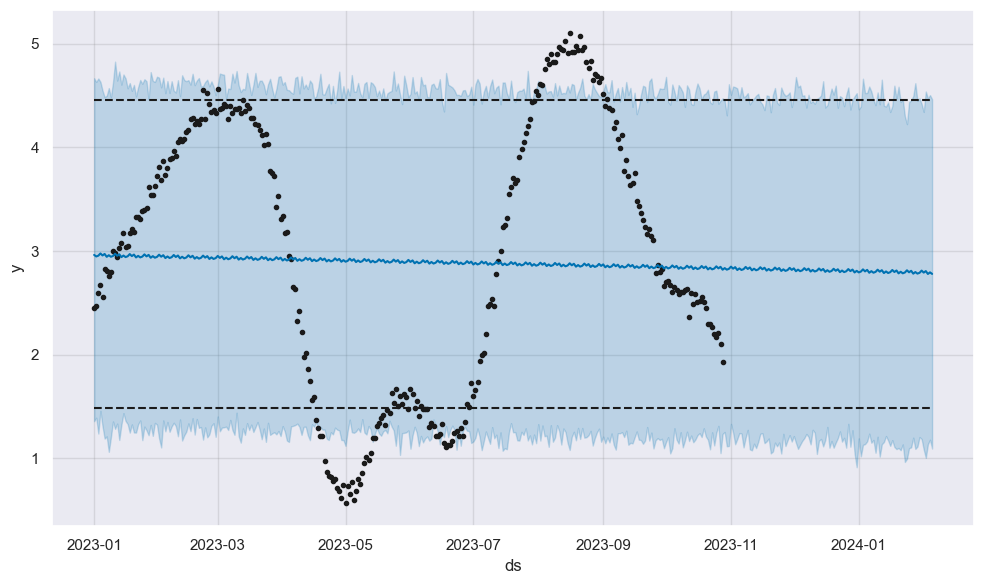

 9 - ABCDE       : 0.15567


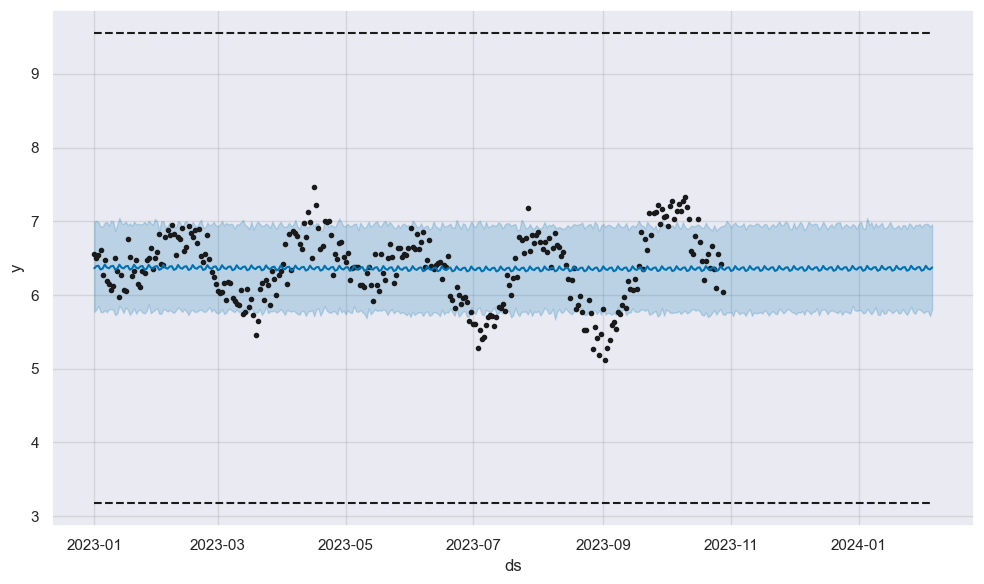

14 - CPU-XYZ     : 0.48237


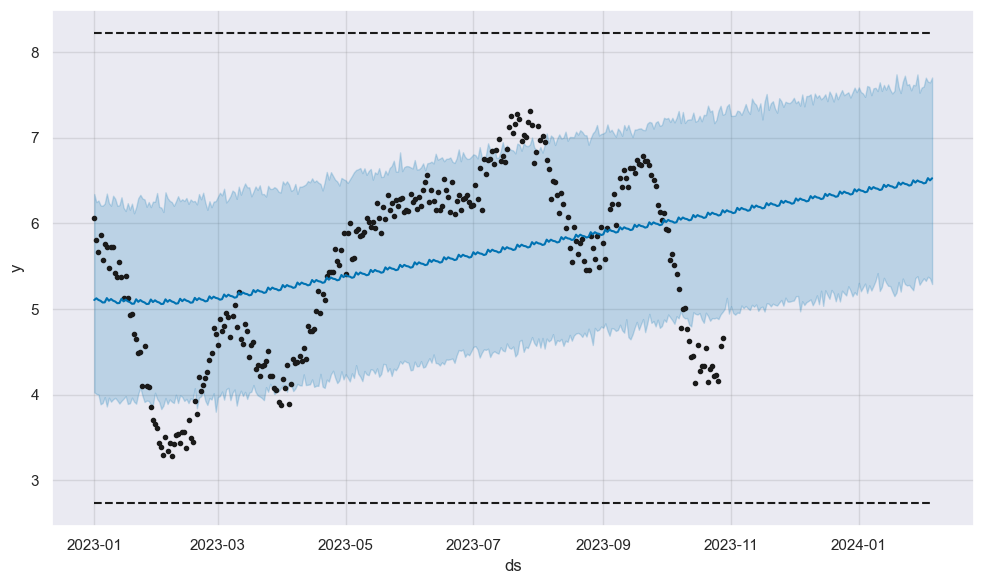

In [202]:
print("Invest in:\n-----------------\n")
for ind, elem in invest:
    print(f"{ind:2} - {ASSETS[ind].name:12}: {elem}")
    _ = get_expected_return_prophet(ASSETS[ind], plot=True)

<h2> <center> Justification of the weights: </center> </h2>

Weights are selected by using Markowitz's model from 1952. The only difference we introduced was instead of using linear regression to calculate expected return we used prophet model to fit the data (from the entire time interval [0; 300]) and we used it to predict the next interval [300; 400].

The prediction gives us three values: yhat_upper, yhat and yhat_lower. The parameter yhat is the expected return at the end of the interval. Parameters yhat_upper and yhat_lower are used to calculate the variance - upper and lower limit.

The final expected return value is calculated as follows:

```
diff = yhat_upper + yhat_lower - 2 * yhat

round((yhat + diff - last) / last, 4)
```

where "diff" is the difference between the upper and expected return and lower and expected return. The "last" parameter is the last value of the asset price at the end of the interval [0; 300].

After all the expected returns are calculated, their values are scalled between -1 and 1 to make better predictions.